# Load the metrics computed on 5 folds of validation splits during the training

In [1]:
import os
import pickle
import glob

def load_geneformer_metrics(base_path):
    """
    Load all metrics.pkl files from Geneformer model folders and organize by cell aggregation level.
    
    Args:
        base_path (str): Path to the directory containing model folders
                        (e.g., '/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/5fold_cv_trained_cell_classification_models/disease_classification/genecorpus_heart_disease/')
    
    Returns:
        dict: Dictionary where keys are cell aggregation levels (e.g., 'singlecell', 'metacell_2', 'metacell_4')
              and values are the loaded pickle dictionaries containing metrics
    """
    metrics_dict = {}
    
    # Pattern to match folders like 30M_singlecell, 30M_metacell_2, etc.
    folder_pattern = os.path.join(base_path, "30M_*")
    
    # Find all matching folders
    folders = glob.glob(folder_pattern)
    
    for folder in folders:
        if os.path.isdir(folder):
            # Extract folder name to get the aggregation level
            folder_name = os.path.basename(folder)
            
            # Extract the aggregation level (everything after '30M_')
            if folder_name.startswith('30M_'):
                aggregation_level = folder_name[4:]  # Remove '30M_' prefix
                
                # Path to the metrics.pkl file
                metrics_file = os.path.join(folder, 'metrics.pkl')
                
                # Check if metrics.pkl exists
                if os.path.exists(metrics_file):
                    try:
                        # Load the pickle file
                        with open(metrics_file, 'rb') as f:
                            metrics_data = pickle.load(f)
                        
                        # Store in the dictionary
                        metrics_dict[aggregation_level] = metrics_data
                        print(f"Loaded metrics for {aggregation_level}")
                        
                    except Exception as e:
                        print(f"Error loading {metrics_file}: {e}")
                else:
                    print(f"metrics.pkl not found in {folder}")
    
    return metrics_dict




In [2]:
base_path = "/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/5fold_cv_trained_cell_classification_models/disease_classification/genecorpus_heart_disease/"

# Load all metrics
all_metrics = load_geneformer_metrics(base_path)

# Print available aggregation levels
print("\nAvailable aggregation levels:")
for level in sorted(all_metrics.keys()):
    print(f"  - {level}")

# Example: Access metrics for a specific aggregation level
if 'singlecell' in all_metrics:
    print(f"\nSinglecell metrics keys: {list(all_metrics['singlecell'].keys())}")

Loaded metrics for metacell_2
Loaded metrics for metacell_4
Loaded metrics for singlecell
Loaded metrics for metacell_8
Loaded metrics for metacell_16

Available aggregation levels:
  - metacell_16
  - metacell_2
  - metacell_4
  - metacell_8
  - singlecell

Singlecell metrics keys: ['1', '2', '3', '4', '5']


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

def plot_geneformer_metrics(all_metrics, output_dir="figures", output_prefix="genecorpus_heart_disease", 
                          whisker_length=2.0, acc_plot_title="Geneformer Accuracy by Cell Aggregation Level", 
                          f1_plot_title="Geneformer F1 Score by Cell Aggregation Level", rotation=45,
                          show_fold_lines=False, legend_position='upper left',
                          acc_ylim=None, f1_ylim=None, level_order=None):
    """
    Plot boxplots for accuracy and F1 scores across different aggregation levels.
    
    Args:
        all_metrics (dict): Dictionary containing metrics for each aggregation level
        output_dir (str): Directory to save the figures (default: "figures")
        output_prefix (str): Prefix for output filenames
        whisker_length (float): Length of boxplot whiskers
        acc_plot_title (str): Title for accuracy plot
        f1_plot_title (str): Title for F1 score plot
        rotation (int): Rotation angle for x-axis labels
        show_fold_lines (bool): Whether to show fold performance lines across aggregation levels
        legend_position (str): Position of legend ('upper left', 'upper right', 'lower left', 'lower right', etc.)
        acc_ylim (tuple): Y-axis limits for accuracy plot (min, max)
        f1_ylim (tuple): Y-axis limits for F1 score plot (min, max)
    """
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)  
    
    # Extract metrics for each aggregation level
    acc_data = []
    f1_data = []
    labels = []
    
    # For fold lines - store data by fold across aggregation levels
    fold_acc_data = {}  # fold_id -> [acc values for each aggregation level]
    fold_f1_data = {}   # fold_id -> [f1 values for each aggregation level]
    
    for level in level_order:
        if level in all_metrics:
            # Extract accuracy and F1 scores for all folds
            acc_scores = []
            f1_scores = []
            
            for fold_key, fold_data in all_metrics[level].items():
                print(f"Processing {level} - {fold_key}")
                print(f"  Accuracy: {fold_data['acc']}, F1 Score: {fold_data['macro_f1']}")
                
                # Extract accuracy and F1 scores
                acc_score = fold_data['acc'][0]
                f1_score = float(fold_data['macro_f1'][0])
                
                acc_scores.append(acc_score)
                f1_scores.append(f1_score)
                
                # Store for fold lines
                if fold_key not in fold_acc_data:
                    fold_acc_data[fold_key] = []
                    fold_f1_data[fold_key] = []
                fold_acc_data[fold_key].append(acc_score)
                fold_f1_data[fold_key].append(f1_score)
            
            acc_data.append(acc_scores)
            f1_data.append(f1_scores)
            labels.append(level)
    
    # Define colors for each fold
    fold_colors = ['#FF6B6B', "#7F35CE", '#45B7D1', "#2013E1", "#0EBB0B"]
    fold_ids = sorted(fold_acc_data.keys())
    
    # Create figure for accuracy
    plt.figure(figsize=(12, 6))
    
    # Plot boxplot
    box_plot = plt.boxplot(acc_data, labels=labels, whis=whisker_length, patch_artist=True)
    
    # Customize boxplot colors (lighter)
    for patch in box_plot['boxes']:
        patch.set_facecolor('#E8F4FD')
        patch.set_alpha(0.7)
    
    # Plot fold lines if requested
    if show_fold_lines:
        x_positions = range(1, len(labels) + 1)
        for i, fold_id in enumerate(fold_ids):
            if len(fold_acc_data[fold_id]) == len(labels):  # Ensure we have data for all aggregation levels
                color = fold_colors[i % len(fold_colors)]
                plt.plot(x_positions, fold_acc_data[fold_id], 
                        marker='o', linewidth=2, markersize=6, 
                        color=color, label=f'Fold {fold_id}',
                        alpha=0.8)
        
        # Add legend
        plt.legend(loc=legend_position, framealpha=0.9)
    
    plt.title(acc_plot_title, fontsize=14, fontweight='bold')
    plt.xlabel('Cell Aggregation Level', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(rotation=rotation)
    plt.grid(True, alpha=0.3)
    
    # Set y-axis limits if provided
    if acc_ylim is not None:
        plt.ylim(acc_ylim)
    
    plt.tight_layout()
    
    # Save accuracy plot
    line_suffix = "_with_folds" if show_fold_lines else ""
    acc_path = os.path.join(output_dir, f'{output_prefix}_accuracy_boxplot{line_suffix}.png')
    plt.savefig(acc_path, dpi=300, bbox_inches='tight')
    plt.savefig(acc_path.replace('.png', '.pdf'), bbox_inches='tight')
    plt.show()
    print(f"Accuracy boxplot saved to {acc_path}")
    plt.close()
    
    # Create figure for F1 score
    plt.figure(figsize=(12, 6))
    
    # Plot boxplot
    box_plot = plt.boxplot(f1_data, labels=labels, whis=whisker_length, patch_artist=True)
    
    # Customize boxplot colors (lighter)
    for patch in box_plot['boxes']:
        patch.set_facecolor('#E8F4FD')
        patch.set_alpha(0.7)
    
    # Plot fold lines if requested
    if show_fold_lines:
        x_positions = range(1, len(labels) + 1)
        for i, fold_id in enumerate(fold_ids):
            if len(fold_f1_data[fold_id]) == len(labels):  # Ensure we have data for all aggregation levels
                color = fold_colors[i % len(fold_colors)]
                plt.plot(x_positions, fold_f1_data[fold_id], 
                        marker='o', linewidth=2, markersize=6, 
                        color=color, label=f'Fold {fold_id}',
                        alpha=0.8)
        
        # Add legend
        plt.legend(loc=legend_position, framealpha=0.9)
    
    plt.title(f1_plot_title, fontsize=14, fontweight='bold')
    plt.xlabel('Cell Aggregation Level', fontsize=12)
    plt.ylabel('Macro F1 Score', fontsize=12)
    plt.xticks(rotation=rotation)
    plt.grid(True, alpha=0.3)
    
    # Set y-axis limits if provided
    if f1_ylim is not None:
        plt.ylim(f1_ylim)
    
    plt.tight_layout()
    
    # Save F1 plot
    f1_path = os.path.join(output_dir, f'{output_prefix}_f1_score_boxplot{line_suffix}.png')
    plt.savefig(f1_path, dpi=300, bbox_inches='tight')
    plt.savefig(f1_path.replace('.png', '.pdf'), bbox_inches='tight')
    plt.show()
    print(f"F1 score boxplot saved to {f1_path}")
    plt.close()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("==================")
    
    for i, level in enumerate(labels):
        print(f"\n{level}:")
        print(f"  Accuracy: {np.mean(acc_data[i]):.4f} ± {np.std(acc_data[i]):.4f}")
        print(f"  F1 Score: {np.mean(f1_data[i]):.4f} ± {np.std(f1_data[i]):.4f}")
    
    # Print fold performance analysis if lines are shown
    if show_fold_lines:
        print("\nFold Performance Analysis:")
        print("==========================")
        
        # Find best and worst performing folds for each metric
        for metric_name, fold_data_dict in [("Accuracy", fold_acc_data), ("F1 Score", fold_f1_data)]:
            print(f"\n{metric_name}:")
            avg_fold_performance = {}
            for fold_id in fold_ids:
                if len(fold_data_dict[fold_id]) == len(labels):
                    avg_fold_performance[fold_id] = np.mean(fold_data_dict[fold_id])
            
            if avg_fold_performance:
                best_fold = max(avg_fold_performance, key=avg_fold_performance.get)
                worst_fold = min(avg_fold_performance, key=avg_fold_performance.get)
                print(f"  Best performing fold: {best_fold} (avg: {avg_fold_performance[best_fold]:.4f})")
                print(f"  Worst performing fold: {worst_fold} (avg: {avg_fold_performance[worst_fold]:.4f})")
    
    # Create a summary DataFrame
    summary_data = []
    for i, level in enumerate(labels):
        summary_data.append({
            'Aggregation_Level': level,
            'Accuracy_Mean': np.mean(acc_data[i]),
            'Accuracy_Std': np.std(acc_data[i]),
            'F1_Mean': np.mean(f1_data[i]),
            'F1_Std': np.std(f1_data[i])
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Save summary statistics
    summary_path = os.path.join(output_dir, f'{output_prefix}_metrics_summary.csv')
    summary_df.to_csv(summary_path, index=False)
    print(f"\nSummary statistics saved to {summary_path}")
    
    return summary_df



Processing singlecell - 1
  Accuracy: [0.6294721272071739], F1 Score: [np.float64(0.5376015113032603)]
Processing singlecell - 2
  Accuracy: [0.6466754035039316], F1 Score: [np.float64(0.5968502868134175)]
Processing singlecell - 3
  Accuracy: [0.6270208160756754], F1 Score: [np.float64(0.619418698979441)]
Processing singlecell - 4
  Accuracy: [0.6257768322042438], F1 Score: [np.float64(0.5687637290319877)]
Processing singlecell - 5
  Accuracy: [0.612022245049768], F1 Score: [np.float64(0.5299988651866353)]
Processing metacell_2 - 1
  Accuracy: [0.6712582046778219], F1 Score: [np.float64(0.5648893589148453)]
Processing metacell_2 - 2
  Accuracy: [0.663953648779142], F1 Score: [np.float64(0.582196600053679)]
Processing metacell_2 - 3
  Accuracy: [0.67899420142693], F1 Score: [np.float64(0.6606591914733717)]
Processing metacell_2 - 4
  Accuracy: [0.6508034264598846], F1 Score: [np.float64(0.5615557411783816)]
Processing metacell_2 - 5
  Accuracy: [0.6672452268782544], F1 Score: [np.float

/tmp/ipykernel_751129/1959173770.py:76: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(acc_data, labels=labels, whis=whisker_length, patch_artist=True)


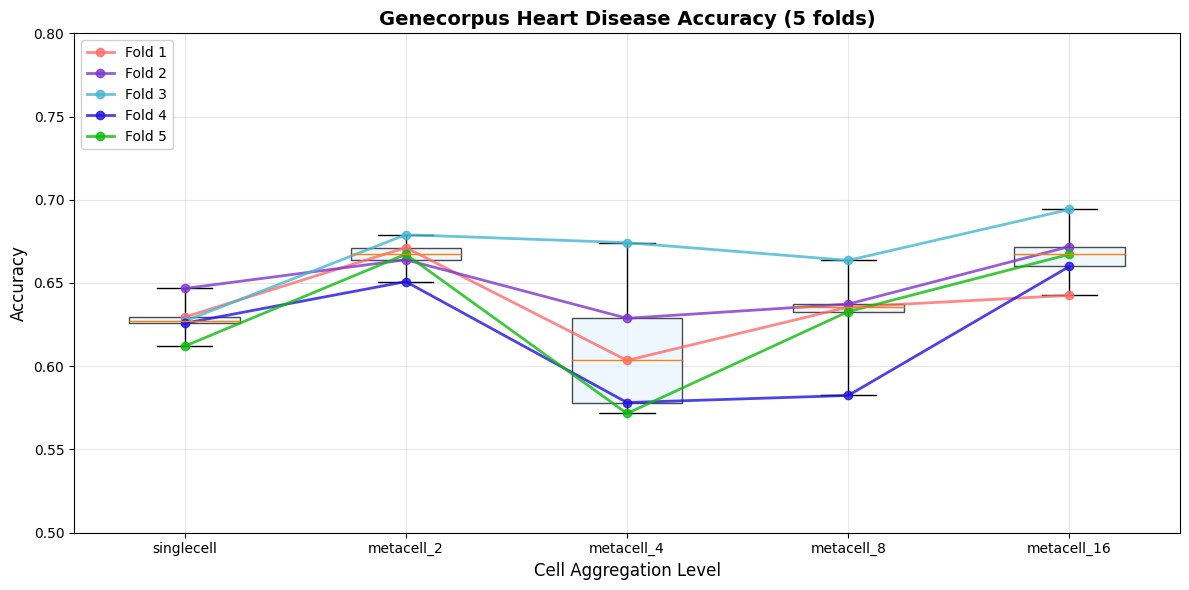

Accuracy boxplot saved to figures/genecorpus_heart_disease_accuracy_boxplot_with_folds.png


/tmp/ipykernel_751129/1959173770.py:122: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(f1_data, labels=labels, whis=whisker_length, patch_artist=True)


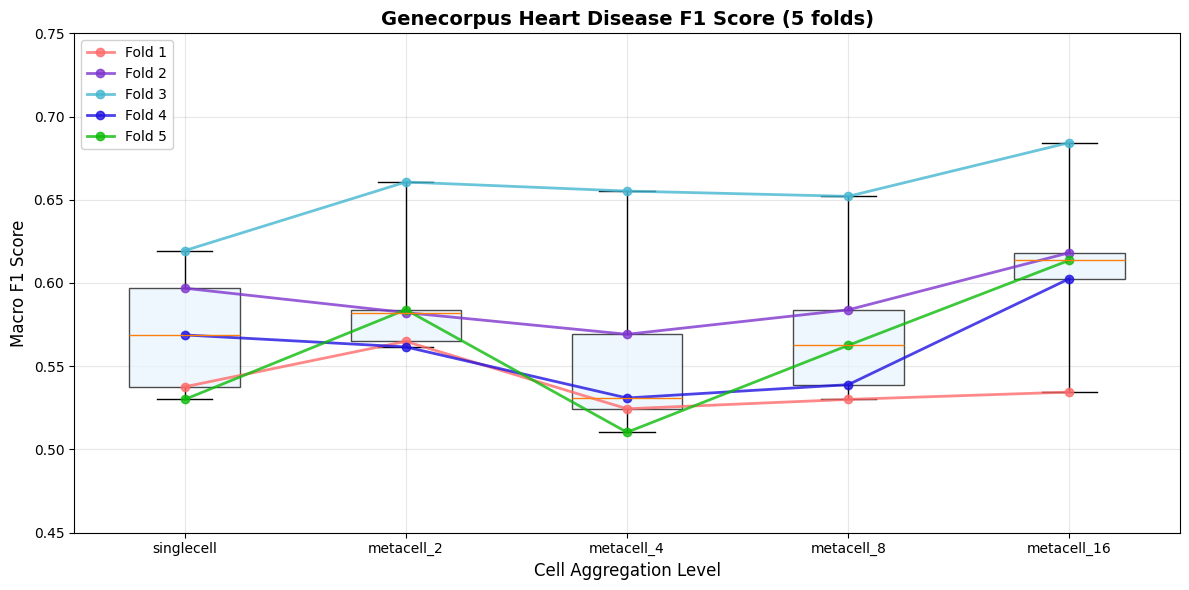

F1 score boxplot saved to figures/genecorpus_heart_disease_f1_score_boxplot_with_folds.png

Summary Statistics:

singlecell:
  Accuracy: 0.6282 ± 0.0111
  F1 Score: 0.5705 ± 0.0341

metacell_2:
  Accuracy: 0.6665 ± 0.0093
  F1 Score: 0.5906 ± 0.0361

metacell_4:
  Accuracy: 0.6112 ± 0.0374
  F1 Score: 0.5580 ± 0.0524

metacell_8:
  Accuracy: 0.6303 ± 0.0264
  F1 Score: 0.5735 ± 0.0436

metacell_16:
  Accuracy: 0.6671 ± 0.0168
  F1 Score: 0.6106 ± 0.0477

Fold Performance Analysis:

Accuracy:
  Best performing fold: 3 (avg: 0.6676)
  Worst performing fold: 4 (avg: 0.6194)

F1 Score:
  Best performing fold: 3 (avg: 0.6543)
  Worst performing fold: 1 (avg: 0.5383)

Summary statistics saved to figures/genecorpus_heart_disease_metrics_summary.csv

Plotting complete!


In [4]:
    # Plot the metrics
summary = plot_geneformer_metrics(all_metrics,
                                  output_dir="figures",
                                  output_prefix="genecorpus_heart_disease",
                                  whisker_length=40.0,
                                  rotation=0,
                                  acc_plot_title="Genecorpus Heart Disease Accuracy (5 folds)",
                                  f1_plot_title="Genecorpus Heart Disease F1 Score (5 folds)",
                                  show_fold_lines=True,
                                  legend_position='upper left',
                                  acc_ylim=(0.5, 0.8),
                                  f1_ylim=(0.45, 0.75),
                                  level_order = ['singlecell', 'metacell_2', 'metacell_4', 'metacell_8', 'metacell_16']
                                  
                                  )
print("\nPlotting complete!")

In [5]:
all_metrics

{'metacell_2': {'1': {'conf_matrix':         dcm     hcm       nf
   dcm  3572.0  4600.0   1783.0
   hcm  2036.0  2388.0    734.0
   nf    618.0   897.0  15823.0,
   'macro_f1': [np.float64(0.5648893589148453)],
   'acc': [0.6712582046778219],
   'all_roc_metrics': None},
  '2': {'conf_matrix':         dcm     hcm      nf
   dcm  1123.0  2794.0   472.0
   hcm  1362.0  8872.0  3133.0
   nf    238.0  1745.0  9257.0,
   'macro_f1': [np.float64(0.582196600053679)],
   'acc': [0.663953648779142],
   'all_roc_metrics': None},
  '3': {'conf_matrix':         dcm      hcm      nf
   dcm  4288.0   3224.0  1391.0
   hcm  2222.0  11245.0  3189.0
   nf    281.0   1706.0  9877.0,
   'macro_f1': [np.float64(0.6606591914733717)],
   'acc': [0.67899420142693],
   'all_roc_metrics': None},
  '4': {'conf_matrix':        dcm     hcm      nf
   dcm  612.0  1712.0   637.0
   hcm  762.0  5829.0  1235.0
   nf   334.0  1557.0  5183.0,
   'macro_f1': [np.float64(0.5615557411783816)],
   'acc': [0.65080342645988

In [6]:
# Assuming your dictionary is stored in `results`
for agg, folds in all_metrics.items():
    best_acc = max(folds.items(), key=lambda x: x[1]['acc'][0])
    best_f1 = max(folds.items(), key=lambda x: x[1]['macro_f1'][0])
    print(f"{agg}: best acc in fold {best_acc[0]}, best f1 in fold {best_f1[0]}")


metacell_2: best acc in fold 3, best f1 in fold 3
metacell_4: best acc in fold 3, best f1 in fold 3
singlecell: best acc in fold 2, best f1 in fold 3
metacell_8: best acc in fold 3, best f1 in fold 3
metacell_16: best acc in fold 3, best f1 in fold 3


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from math import ceil, sqrt

def plot_confusion_matrices(all_metrics, aggregation_level, normalize_cm=False, 
                          save_file_prefix="", rotate_x_ticks=False, output_dir="figures",
                          class_order=None):
    """
    Plot confusion matrices for each fold and create a combined confusion matrix.
    
    Args:
        all_metrics (dict): Dictionary containing metrics for each aggregation level
        aggregation_level (str): The aggregation level to plot (e.g., 'singlecell', 'metacell_2')
        normalize_cm (bool): Whether to normalize the confusion matrix
        save_file_prefix (str): Prefix to append to saved file names
        rotate_x_ticks (bool): Whether to rotate x-axis labels
        output_dir (str): Directory to save the figures
        class_order (list): Desired order of class labels. If None, uses ['dcm', 'hcm', 'nf']
    """
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    if aggregation_level not in all_metrics:
        raise ValueError(f"Aggregation level '{aggregation_level}' not found in metrics")
    
    metrics = all_metrics[aggregation_level]
    n_folds = len(metrics)
    
    # Calculate subplot dimensions
    n_cols = min(3, n_folds)  # Max 3 columns for better readability
    n_rows = ceil(n_folds / n_cols)
    
    # Create figure for individual fold confusion matrices
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_folds == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Define consistent class order
    if class_order is None:
        # Default order based on your data: dcm, hcm, nf
        desired_class_order = ['dcm', 'hcm', 'nf']
    else:
        desired_class_order = class_order
    
    # Get class names from the first confusion matrix and reorder them consistently
    first_cm = metrics['1']['conf_matrix']
    available_classes = first_cm.index.tolist()
    
    # Use the desired order, but only include classes that actually exist
    class_names = [cls for cls in desired_class_order if cls in available_classes]
    
    # Add any remaining classes that weren't in our desired order (just in case)
    for cls in available_classes:
        if cls not in class_names:
            class_names.append(cls)
    
    # Store all confusion matrices for later combination
    all_cms = []
    
    # Plot each fold's confusion matrix
    for i, (fold_key, fold_data) in enumerate(metrics.items()):
        row = i // n_cols
        col = i % n_cols
        
        if n_rows == 1:
            ax = axes[col]
        else:
            ax = axes[row, col]
        
        cm = fold_data['conf_matrix']
        
        # Reorder the confusion matrix to match our desired class order
        cm_reordered = cm.reindex(index=class_names, columns=class_names)
        all_cms.append(cm_reordered)
        
        # Convert to numpy array for easier manipulation
        cm_array = cm_reordered.values
        
        # Calculate class counts for labels (using reordered matrix)
        class_counts = {}
        for class_name in class_names:
            class_counts[class_name] = int(cm_reordered.sum(axis=1)[class_name])
        
        # Create labels with counts
        labels_with_counts = [f"{name}\nn={class_counts[name]}" for name in class_names]
        
        if normalize_cm:
            # Normalize by row (true labels)
            cm_normalized = cm_array.astype('float') / cm_array.sum(axis=1)[:, np.newaxis]
            im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
            
            # Add text annotations
            thresh = cm_normalized.max() / 2.
            for i_cm in range(cm_normalized.shape[0]):
                for j_cm in range(cm_normalized.shape[1]):
                    ax.text(j_cm, i_cm, f'{cm_normalized[i_cm, j_cm]:.2f}',
                           ha="center", va="center",
                           color="white" if cm_normalized[i_cm, j_cm] > thresh else "black",
                           fontweight='bold')
        else:
            im = ax.imshow(cm_array, interpolation='nearest', cmap='Blues')
            
            # Add text annotations
            thresh = cm_array.max() / 2.
            for i_cm in range(cm_array.shape[0]):
                for j_cm in range(cm_array.shape[1]):
                    ax.text(j_cm, i_cm, f'{int(cm_array[i_cm, j_cm])}',
                           ha="center", va="center",
                           color="white" if cm_array[i_cm, j_cm] > thresh else "black",
                           fontweight='bold')
        
        ax.set_title(f'Fold {fold_key}', fontsize=12, fontweight='bold')
        ax.set_ylabel('True label', fontsize=10)
        ax.set_xlabel('Predicted label', fontsize=10)
        
        # Set ticks and labels
        ax.set_xticks(range(len(class_names)))
        ax.set_yticks(range(len(class_names)))
        ax.set_xticklabels(labels_with_counts, rotation=45 if rotate_x_ticks else 0)
        ax.set_yticklabels(labels_with_counts)
        
        # Add colorbar
        plt.colorbar(im, ax=ax, shrink=0.8)
    
    # Hide unused subplots
    for i in range(n_folds, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        if n_rows == 1:
            axes[col].set_visible(False)
        else:
            axes[row, col].set_visible(False)
    
    # Adjust layout and save individual folds figure
    plt.tight_layout()
    
    # Create filename
    norm_suffix = "_normalized" if normalize_cm else ""
    prefix = f"{save_file_prefix}_" if save_file_prefix else ""
    
    individual_filename = f"{prefix}{aggregation_level}_individual_folds{norm_suffix}.png"
    individual_path = os.path.join(output_dir, individual_filename)
    
    plt.savefig(individual_path, dpi=300, bbox_inches='tight')
    plt.savefig(individual_path.replace('.png', '.pdf'), bbox_inches='tight')
    print(f"Individual fold confusion matrices saved to {individual_path}")
    plt.show()
    plt.close()
    
    # Create combined confusion matrix
    combined_cm = sum(all_cms)
    combined_array = combined_cm.values
    
    # Calculate class counts for combined matrix
    combined_class_counts = {}
    for class_name in class_names:
        combined_class_counts[class_name] = int(combined_cm.sum(axis=1)[class_name])
    
    combined_labels_with_counts = [f"{name}\nn={combined_class_counts[name]}" for name in class_names]
    
    # Create figure for combined confusion matrix
    plt.figure(figsize=(8, 6))
    
    if normalize_cm:
        # Normalize by row (true labels)
        combined_normalized = combined_array.astype('float') / combined_array.sum(axis=1)[:, np.newaxis]
        im = plt.imshow(combined_normalized, interpolation='nearest', cmap='Blues')
        
        # Add text annotations
        thresh = combined_normalized.max() / 2.
        for i in range(combined_normalized.shape[0]):
            for j in range(combined_normalized.shape[1]):
                plt.text(j, i, f'{combined_normalized[i, j]:.2f}',
                        ha="center", va="center",
                        color="white" if combined_normalized[i, j] > thresh else "black",
                        fontweight='bold', fontsize=14)
    else:
        im = plt.imshow(combined_array, interpolation='nearest', cmap='Blues')
        
        # Add text annotations
        thresh = combined_array.max() / 2.
        for i in range(combined_array.shape[0]):
            for j in range(combined_array.shape[1]):
                plt.text(j, i, f'{int(combined_array[i, j])}',
                        ha="center", va="center",
                        color="white" if combined_array[i, j] > thresh else "black",
                        fontweight='bold', fontsize=14)
    
    plt.title(f'{aggregation_level.replace("_", " ").title()} - Combined Confusion Matrix', 
              fontsize=14, fontweight='bold')
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    
    # Set ticks and labels
    plt.xticks(range(len(class_names)), combined_labels_with_counts, 
               rotation=45 if rotate_x_ticks else 0)
    plt.yticks(range(len(class_names)), combined_labels_with_counts)
    
    # Add colorbar
    plt.colorbar(im, shrink=0.8)
    plt.tight_layout()
    
    # Save combined confusion matrix
    combined_filename = f"{prefix}{aggregation_level}_combined{norm_suffix}.png"
    combined_path = os.path.join(output_dir, combined_filename)
    
    plt.savefig(combined_path, dpi=300, bbox_inches='tight')
    plt.savefig(combined_path.replace('.png', '.pdf'), bbox_inches='tight')
    plt.show()
    print(f"Combined confusion matrix saved to {combined_path}")
    plt.close()
    
    return combined_cm



Individual fold confusion matrices saved to figures/genecorpus_heart_disease_singlecell_individual_folds_normalized.png


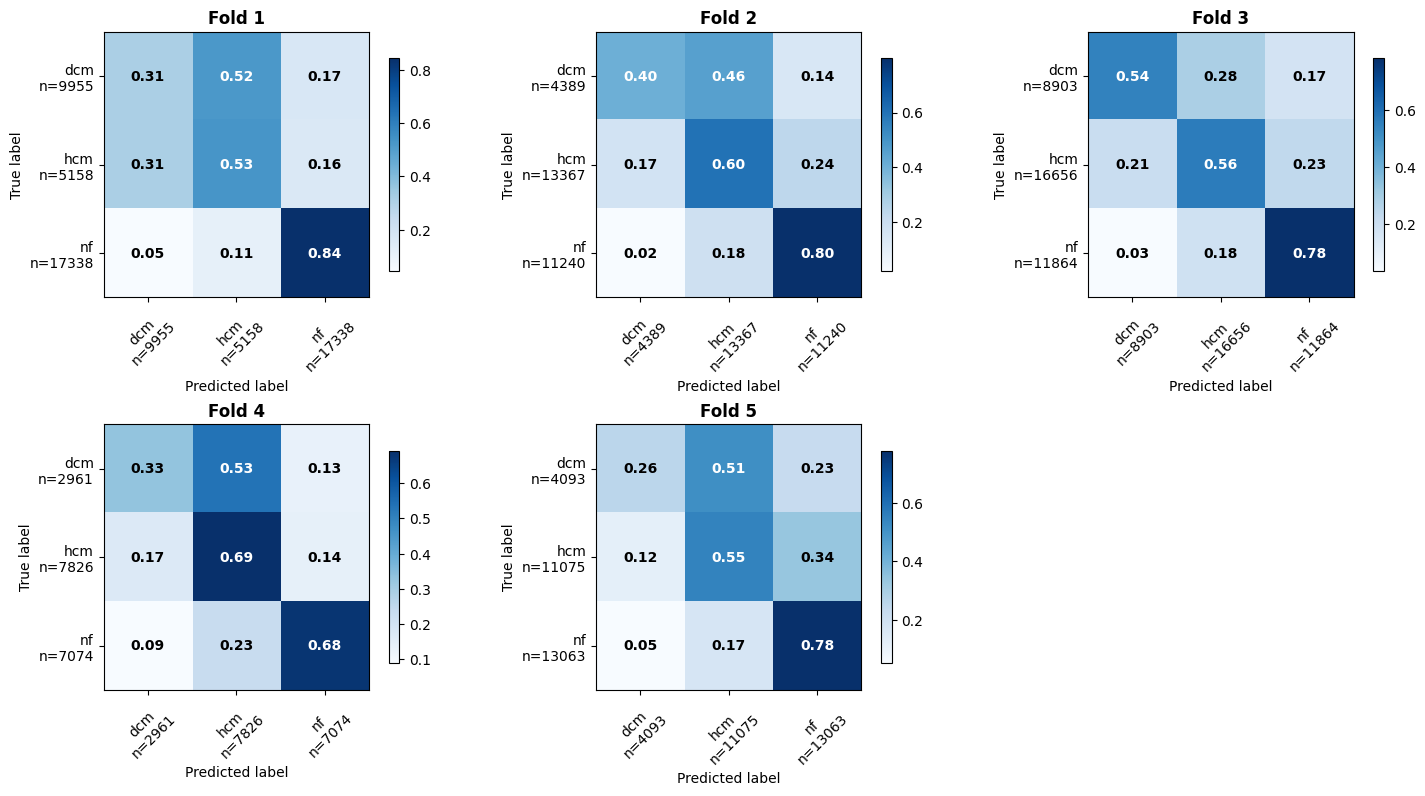

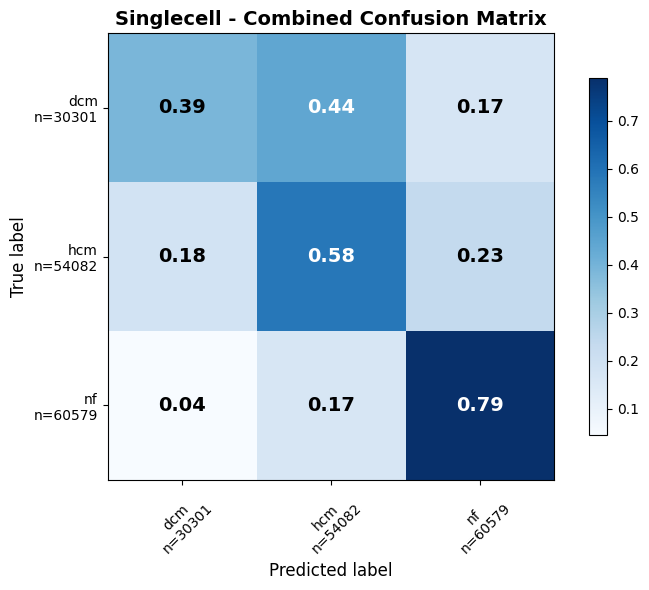

Combined confusion matrix saved to figures/genecorpus_heart_disease_singlecell_combined_normalized.png
Individual fold confusion matrices saved to figures/genecorpus_heart_disease_metacell_2_individual_folds_normalized.png


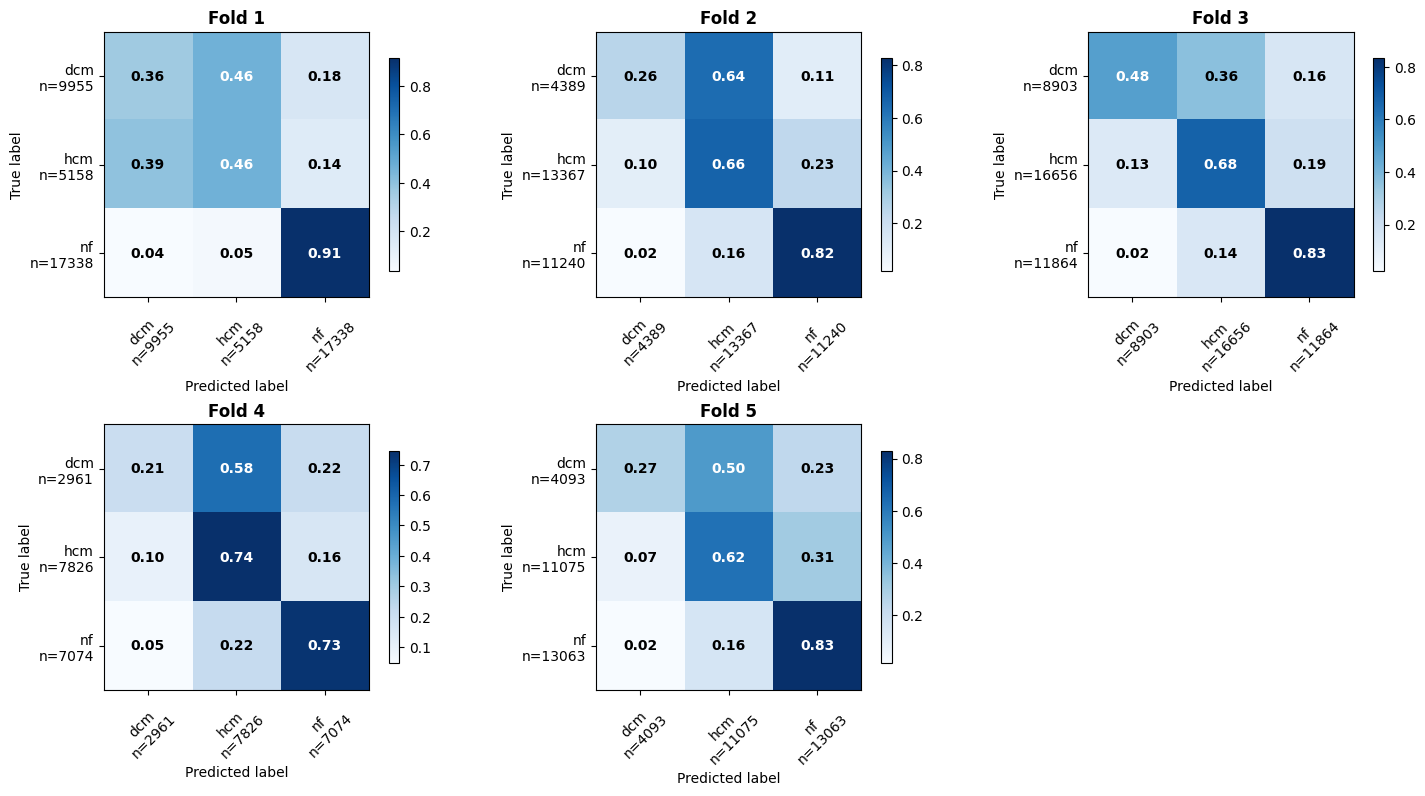

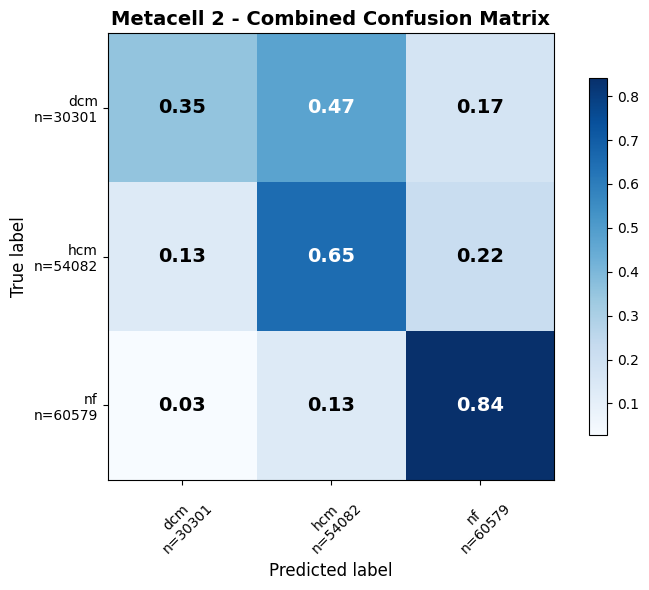

Combined confusion matrix saved to figures/genecorpus_heart_disease_metacell_2_combined_normalized.png
Individual fold confusion matrices saved to figures/genecorpus_heart_disease_metacell_4_individual_folds_normalized.png


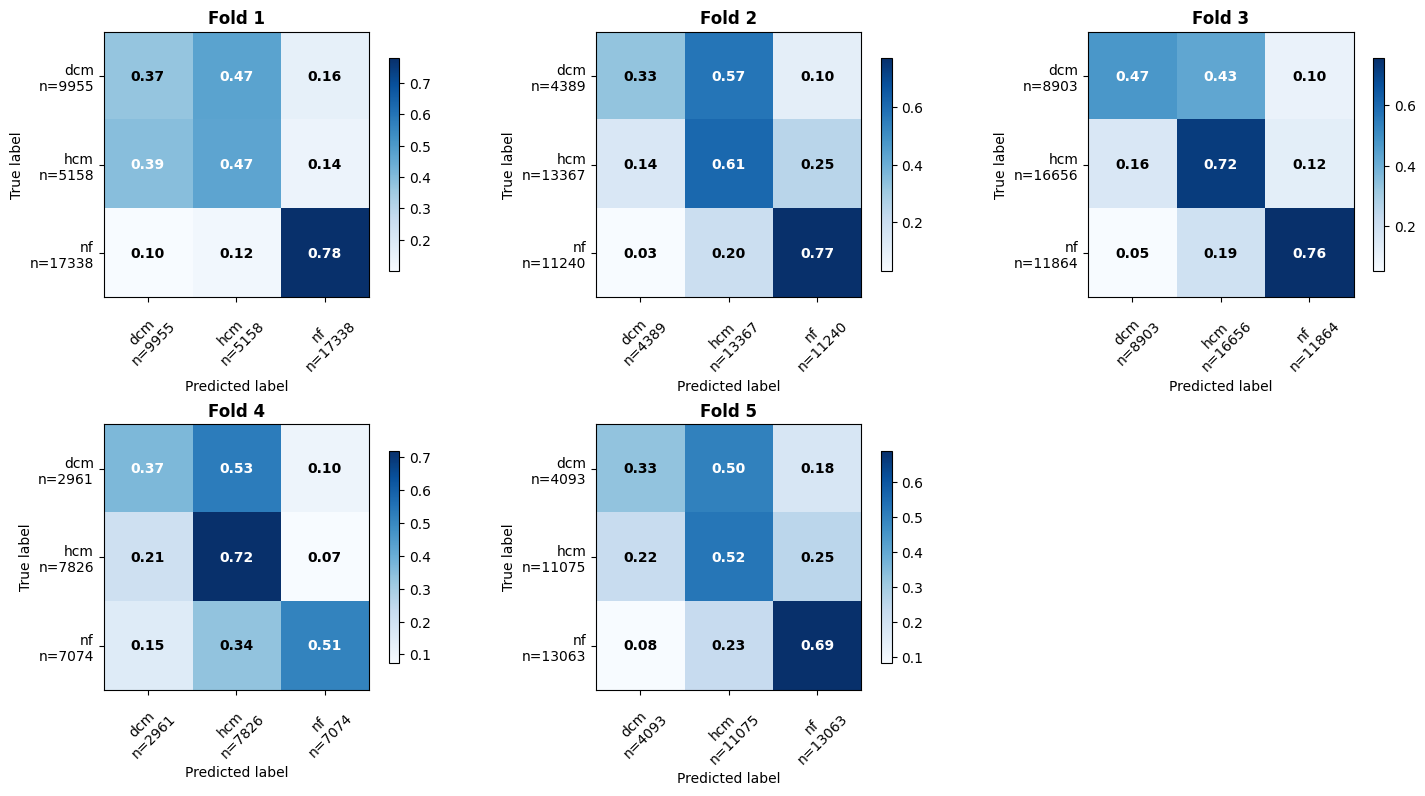

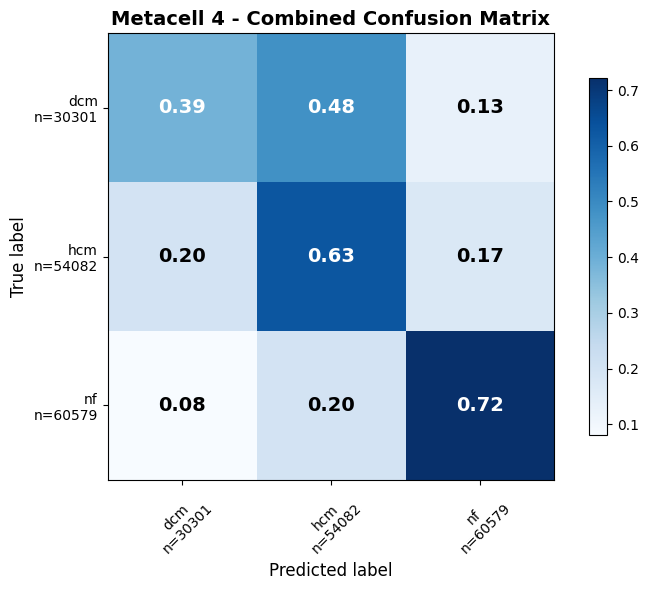

Combined confusion matrix saved to figures/genecorpus_heart_disease_metacell_4_combined_normalized.png
Individual fold confusion matrices saved to figures/genecorpus_heart_disease_metacell_8_individual_folds_normalized.png


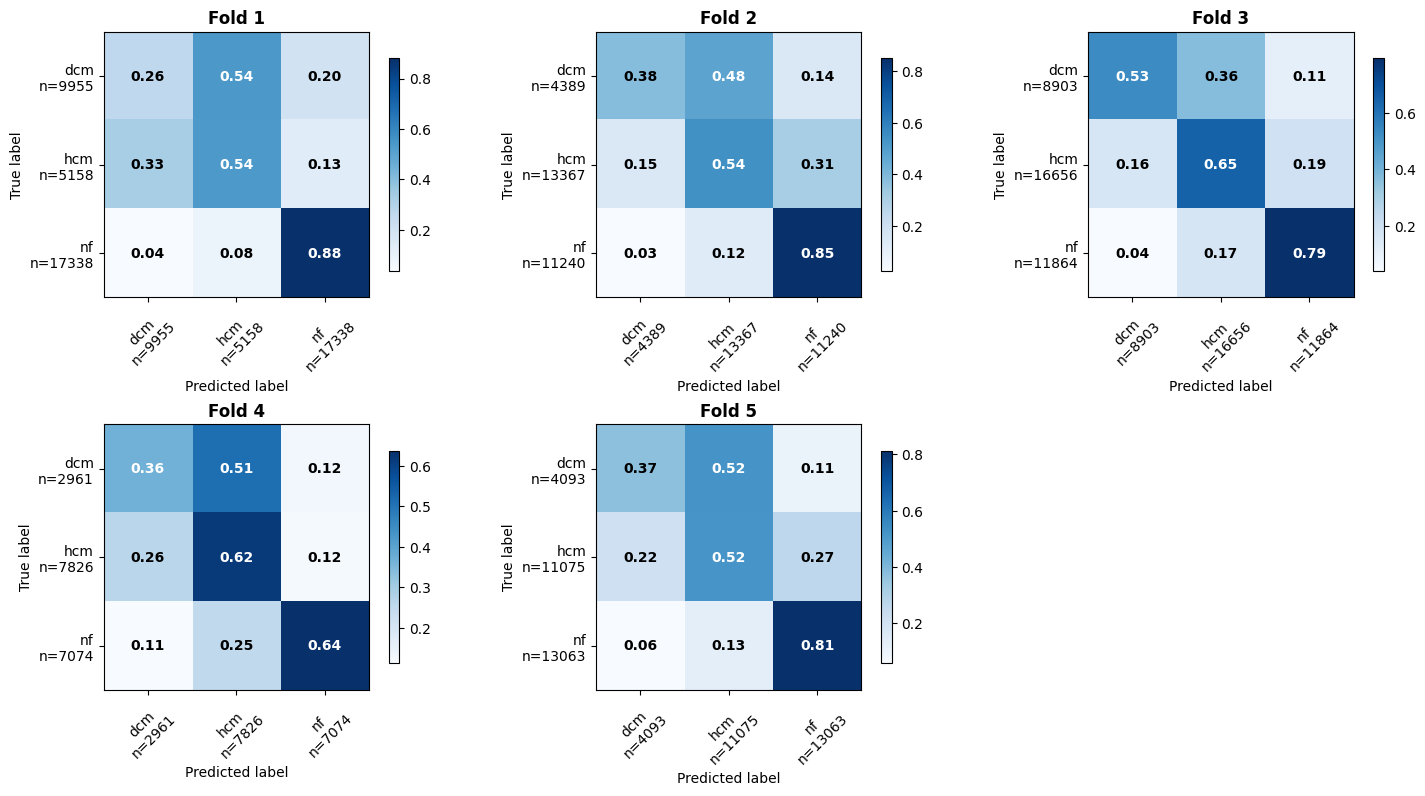

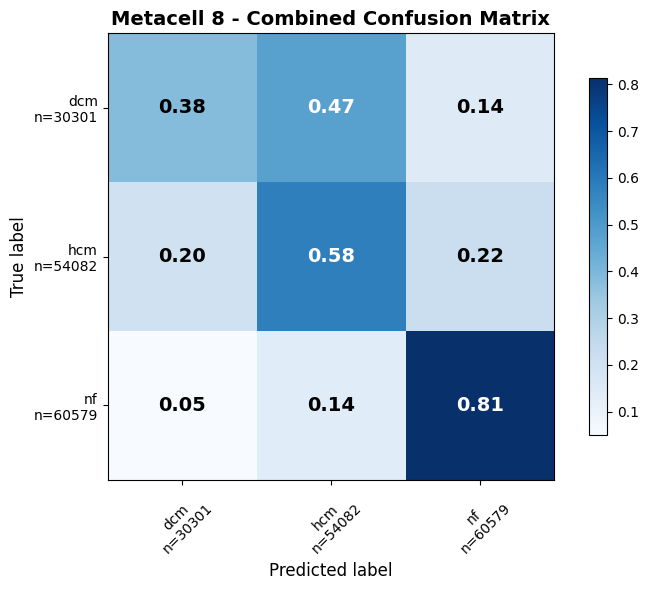

Combined confusion matrix saved to figures/genecorpus_heart_disease_metacell_8_combined_normalized.png
Individual fold confusion matrices saved to figures/genecorpus_heart_disease_metacell_16_individual_folds_normalized.png


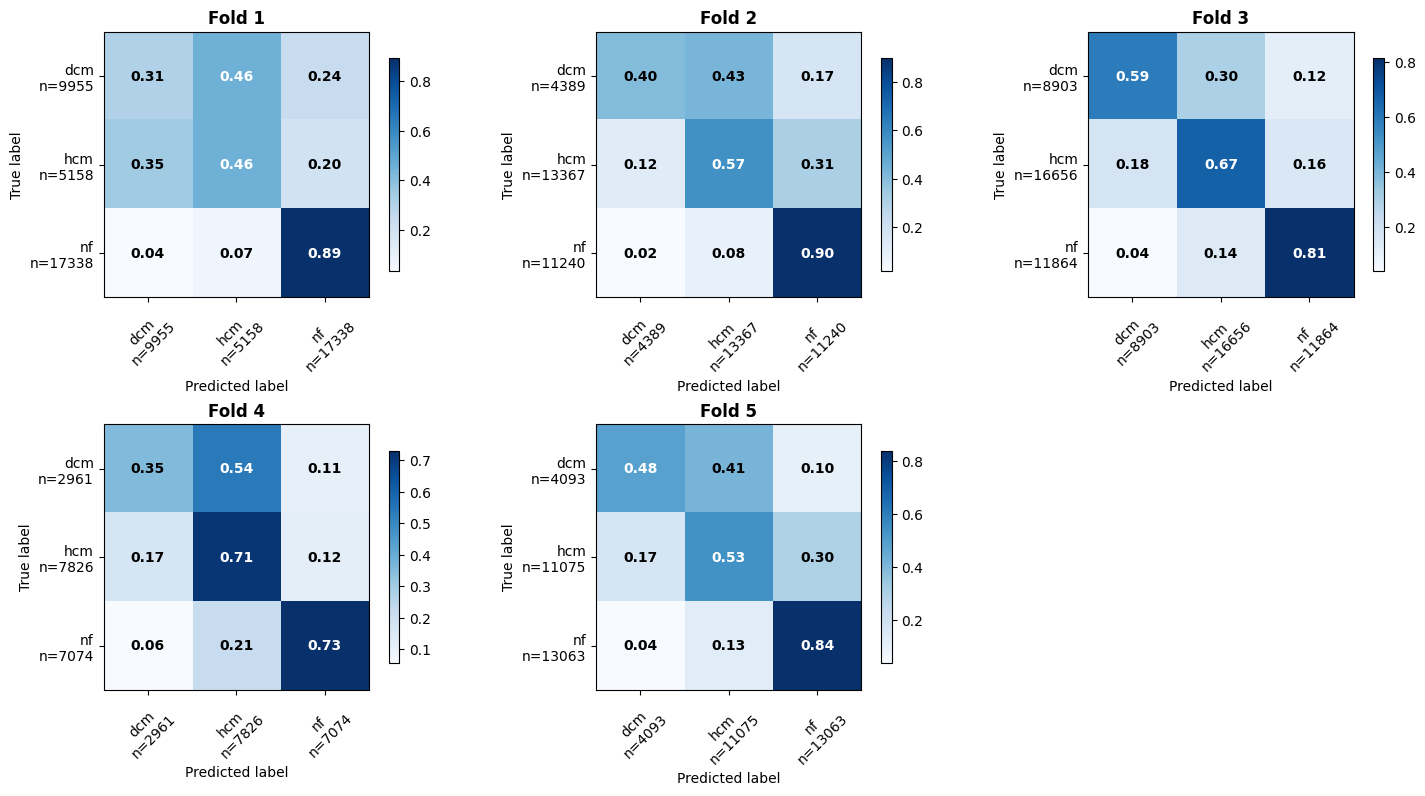

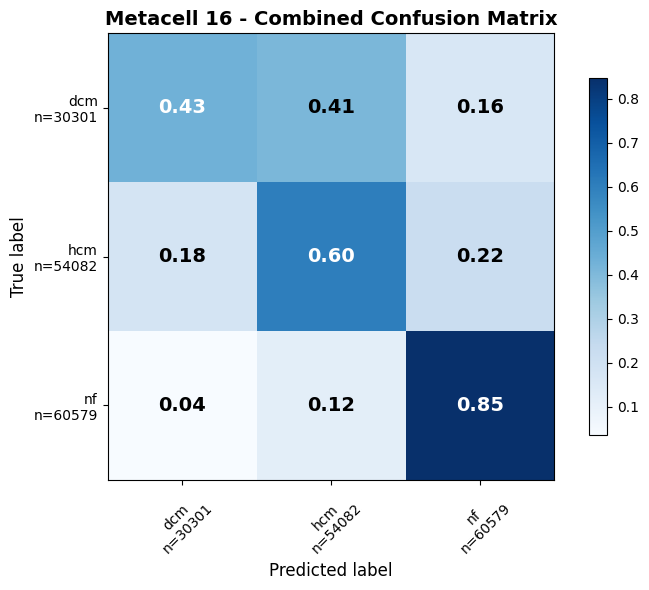

Combined confusion matrix saved to figures/genecorpus_heart_disease_metacell_16_combined_normalized.png


In [8]:
# Plot confusion matrices for singlecell aggregation
# combined_cm = plot_confusion_matrices(
#     all_metrics, 
#     aggregation_level='singlecell',
#     normalize_cm=True,
#     save_file_prefix="geneformer",
#     rotate_x_ticks=True,
# class_order=['dcm', 'hcm', 'nf']
# )
    
    # Plot for all aggregation levels
aggregation_levels = ['singlecell', 'metacell_2', 'metacell_4', 'metacell_8', 'metacell_16']
for level in aggregation_levels:
    if level in all_metrics:
        plot_confusion_matrices(
            all_metrics, 
            aggregation_level=level,
            normalize_cm=True,
            save_file_prefix="genecorpus_heart_disease",
            rotate_x_ticks=True,
            class_order=['dcm', 'hcm', 'nf']
        )
    


# Graphs for Dosage Sensitivity (Genecorpus)

In [9]:
base_path = "/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/5fold_cv_trained_gene_classification_models/dosage_sensitivity/genecorpus_dosage_sensitivity/"

# Load all metrics
all_metrics = load_geneformer_metrics(base_path)

# Print available aggregation levels
print("\nAvailable aggregation levels:")
for level in sorted(all_metrics.keys()):
    print(f"  - {level}")

# Example: Access metrics for a specific aggregation level
if 'singlecell' in all_metrics:
    print(f"\nSinglecell metrics keys: {list(all_metrics['singlecell'].keys())}")

Loaded metrics for metacell_2
Loaded metrics for metacell_4
Loaded metrics for singlecell
Loaded metrics for metacell_8
Loaded metrics for metacell_16

Available aggregation levels:
  - metacell_16
  - metacell_2
  - metacell_4
  - metacell_8
  - singlecell

Singlecell metrics keys: ['conf_matrix', 'macro_f1', 'acc', 'all_roc_metrics']


In [10]:
restructured = {}

for dataset_key, metrics in all_metrics.items():
    restructured[dataset_key] = {}
    macro_f1s = metrics["macro_f1"]
    accs = metrics["acc"]
    roc_aucs = metrics["all_roc_metrics"]["all_roc_auc"]

    for i in range(len(macro_f1s)):
        fold_key = str(i + 1)
        restructured[dataset_key][fold_key] = {
            "macro_f1": [float(macro_f1s[i])],
            "acc": [float(accs[i])],
            "all_roc_metrics": float(roc_aucs[i]),
            "conf_matrix": None
        }


In [11]:
all_metrics

{'metacell_2': {'conf_matrix':                         Dosage-sensitive TFs  Dosage-insensitive TFs
  Dosage-sensitive TFs                147231.0                 37129.0
  Dosage-insensitive TFs               26849.0                175014.0,
  'macro_f1': [np.float64(0.844862875472874),
   np.float64(0.7911644790461996),
   np.float64(0.8728257416413263),
   np.float64(0.8280459699554541),
   np.float64(0.8234742802141408)],
  'acc': [0.84756172966734,
   0.7925009053753428,
   0.8728468563185369,
   0.828310911414755,
   0.829036946378031],
  'all_roc_metrics': {'mean_tpr': array([0.        , 0.26496439, 0.36126312, 0.43324799, 0.48911282,
          0.53536496, 0.57625689, 0.61169652, 0.64331078, 0.67125372,
          0.69681922, 0.72105107, 0.74278918, 0.76241164, 0.78023293,
          0.79610913, 0.81059273, 0.82455197, 0.83682516, 0.8486713 ,
          0.85955425, 0.86853137, 0.87658447, 0.8846847 , 0.89123583,
          0.89801134, 0.90389103, 0.9091019 , 0.91395882, 0.91802578,


In [12]:
level_order = ['singlecell', 'metacell_2', 'metacell_4', 'metacell_8', 'metacell_16']

# Assuming your dictionary is named `results_dict`
restructured = {level: restructured[level] for level in level_order if level in restructured}


In [13]:
restructured

{'singlecell': {'1': {'macro_f1': [0.8692631140590438],
   'acc': [0.8713741978921912],
   'all_roc_metrics': 0.9473586392625564,
   'conf_matrix': None},
  '2': {'macro_f1': [0.7914017448949022],
   'acc': [0.7933286771172849],
   'all_roc_metrics': 0.8782162258878168,
   'conf_matrix': None},
  '3': {'macro_f1': [0.8604900641097397],
   'acc': [0.8607562439638626],
   'all_roc_metrics': 0.9510077478300403,
   'conf_matrix': None},
  '4': {'macro_f1': [0.8502464912088189],
   'acc': [0.8515805146719724],
   'all_roc_metrics': 0.9244970530854213,
   'conf_matrix': None},
  '5': {'macro_f1': [0.7996638735596622],
   'acc': [0.805629924271399],
   'all_roc_metrics': 0.84097370892165,
   'conf_matrix': None}},
 'metacell_2': {'1': {'macro_f1': [0.844862875472874],
   'acc': [0.84756172966734],
   'all_roc_metrics': 0.912838128204309,
   'conf_matrix': None},
  '2': {'macro_f1': [0.7911644790461996],
   'acc': [0.7925009053753428],
   'all_roc_metrics': 0.8652318324391413,
   'conf_matrix'

In [14]:
all_metrics = {level: all_metrics[level] for level in level_order if level in all_metrics}


In [15]:
all_metrics

{'singlecell': {'conf_matrix':                         Dosage-sensitive TFs  Dosage-insensitive TFs
  Dosage-sensitive TFs                148179.0                 36181.0
  Dosage-insensitive TFs               27059.0                174804.0,
  'macro_f1': [np.float64(0.8692631140590438),
   np.float64(0.7914017448949022),
   np.float64(0.8604900641097397),
   np.float64(0.8502464912088189),
   np.float64(0.7996638735596622)],
  'acc': [0.8713741978921912,
   0.7933286771172849,
   0.8607562439638626,
   0.8515805146719724,
   0.805629924271399],
  'all_roc_metrics': {'mean_tpr': array([0.        , 0.34209826, 0.41456345, 0.46240865, 0.50179701,
          0.53262599, 0.56128589, 0.58681324, 0.60970536, 0.6309399 ,
          0.65055441, 0.66912688, 0.68707414, 0.70487903, 0.72298562,
          0.74214493, 0.76310964, 0.78439356, 0.8042215 , 0.82114657,
          0.83693054, 0.8508657 , 0.8623804 , 0.87261008, 0.88132697,
          0.88973046, 0.89695624, 0.90329918, 0.90899239, 0.914217

Processing singlecell - 1
  Accuracy: [0.8713741978921912], F1 Score: [0.8692631140590438]
Processing singlecell - 2
  Accuracy: [0.7933286771172849], F1 Score: [0.7914017448949022]
Processing singlecell - 3
  Accuracy: [0.8607562439638626], F1 Score: [0.8604900641097397]
Processing singlecell - 4
  Accuracy: [0.8515805146719724], F1 Score: [0.8502464912088189]
Processing singlecell - 5
  Accuracy: [0.805629924271399], F1 Score: [0.7996638735596622]
Processing metacell_2 - 1
  Accuracy: [0.84756172966734], F1 Score: [0.844862875472874]
Processing metacell_2 - 2
  Accuracy: [0.7925009053753428], F1 Score: [0.7911644790461996]
Processing metacell_2 - 3
  Accuracy: [0.8728468563185369], F1 Score: [0.8728257416413263]
Processing metacell_2 - 4
  Accuracy: [0.828310911414755], F1 Score: [0.8280459699554541]
Processing metacell_2 - 5
  Accuracy: [0.829036946378031], F1 Score: [0.8234742802141408]
Processing metacell_4 - 1
  Accuracy: [0.769666240707916], F1 Score: [0.7604994746245061]
Proces

/tmp/ipykernel_751129/1959173770.py:76: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(acc_data, labels=labels, whis=whisker_length, patch_artist=True)


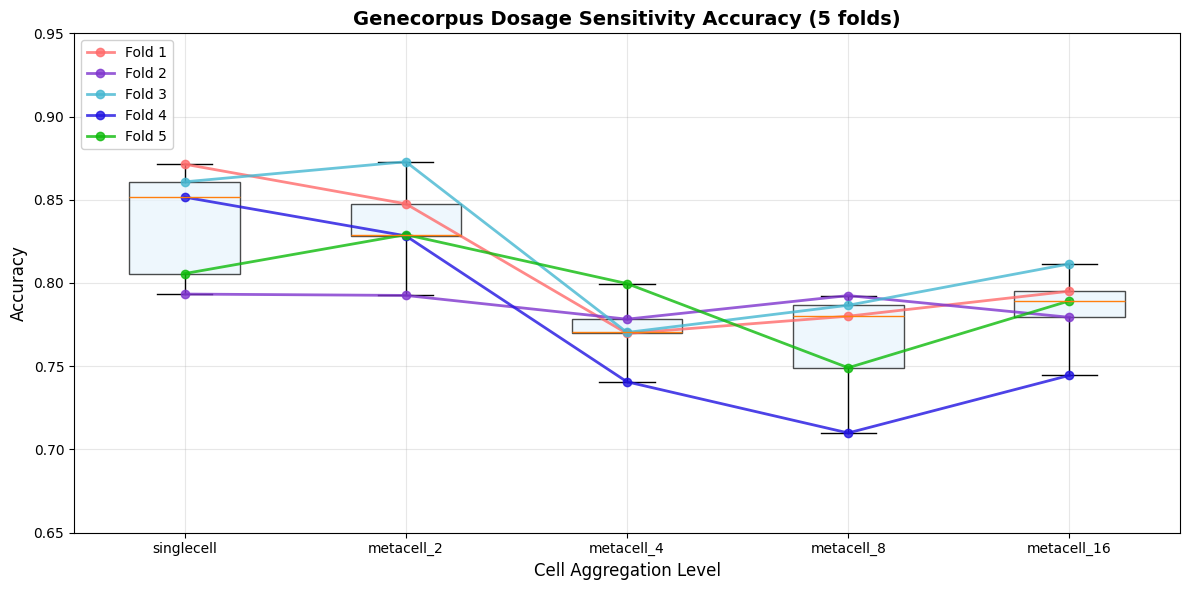

Accuracy boxplot saved to figures/genecorpus_dosage_sensitivity_accuracy_boxplot_with_folds.png


/tmp/ipykernel_751129/1959173770.py:122: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(f1_data, labels=labels, whis=whisker_length, patch_artist=True)


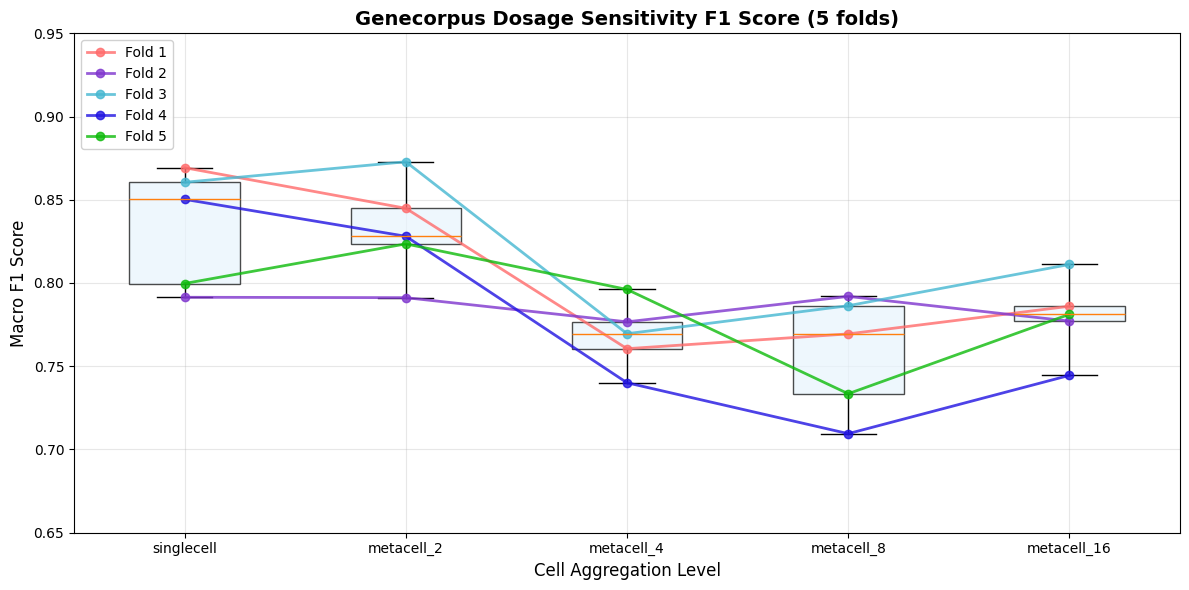

F1 score boxplot saved to figures/genecorpus_dosage_sensitivity_f1_score_boxplot_with_folds.png

Summary Statistics:

singlecell:
  Accuracy: 0.8365 ± 0.0311
  F1 Score: 0.8342 ± 0.0323

metacell_2:
  Accuracy: 0.8341 ± 0.0264
  F1 Score: 0.8321 ± 0.0268

metacell_4:
  Accuracy: 0.7717 ± 0.0190
  F1 Score: 0.7686 ± 0.0185

metacell_8:
  Accuracy: 0.7636 ± 0.0308
  F1 Score: 0.7581 ± 0.0318

metacell_16:
  Accuracy: 0.7839 ± 0.0223
  F1 Score: 0.7800 ± 0.0213

Fold Performance Analysis:

Accuracy:
  Best performing fold: 3 (avg: 0.8204)
  Worst performing fold: 4 (avg: 0.7750)

F1 Score:
  Best performing fold: 3 (avg: 0.8201)
  Worst performing fold: 4 (avg: 0.7744)

Summary statistics saved to figures/genecorpus_dosage_sensitivity_metrics_summary.csv

Plotting complete!


In [16]:
    # Plot the metrics
summary = plot_geneformer_metrics(restructured,
                                  output_dir="figures",
                                  output_prefix="genecorpus_dosage_sensitivity",
                                  whisker_length=40.0,
                                  rotation=0,
                                  acc_plot_title="Genecorpus Dosage Sensitivity Accuracy (5 folds)",
                                  f1_plot_title="Genecorpus Dosage Sensitivity F1 Score (5 folds)",
                                  show_fold_lines=True,
                                  legend_position='upper left',
                                  acc_ylim=(0.65, 0.95),
                                  f1_ylim=(0.65, 0.95),
                                  level_order = ['singlecell', 'metacell_2', 'metacell_4', 'metacell_8', 'metacell_16']
                                  
                                  )
print("\nPlotting complete!")

In [17]:
from geneformer import Classifier

DATASET_PATH = "/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer/datasets/dosage_sensitivity/genecorpus_dosage_sensitivity"

with open(os.path.join(DATASET_PATH, "dosage_sensitivity_TFs.pickle"), "rb") as fp:
    gene_class_dict = pickle.load(fp)
BASE_DIR = "/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/geneformer"

TOKEN_DICTIONARY_FILE = os.path.join(BASE_DIR, "Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl")


training_args = {
    "num_train_epochs": 10,
    "learning_rate": 0.000804,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay":0.258828,
    "per_device_train_batch_size": 128,
    "seed": 73,
    "evaluation_strategy":"epoch",        # Evaluate every epoch
    "save_strategy":"epoch",              # Save checkpoint every epoch
    "metric_for_best_model":"eval_loss",  # Metric to determine "best" model
    "greater_is_better":False,            # For loss, lower is better
    "load_best_model_at_end":True,        # KEY: Load best model at the end
    "save_total_limit":3,                 # Keep only 3 best checkpoints
    # "logging_dir": os.path.normpath("D:/geneformer_finetuning/trained_cell_classification_models/disease_classification/genecorpus_heart_disease/30M_metacell_8/250623_geneformer_cellClassifier_genecorpus_heart_disease_test/ksplit1/runs"),
}

cc = Classifier(classifier="gene",
                gene_class_dict = gene_class_dict,
                max_ncells = None, # Set to None for no limit on number of cells
                freeze_layers = 4,
                num_crossval_splits = 5,
                forward_batch_size=200,
                token_dictionary_file = TOKEN_DICTIONARY_FILE,
                nproc=16,
                training_args=training_args)

<Figure size 1000x1000 with 0 Axes>

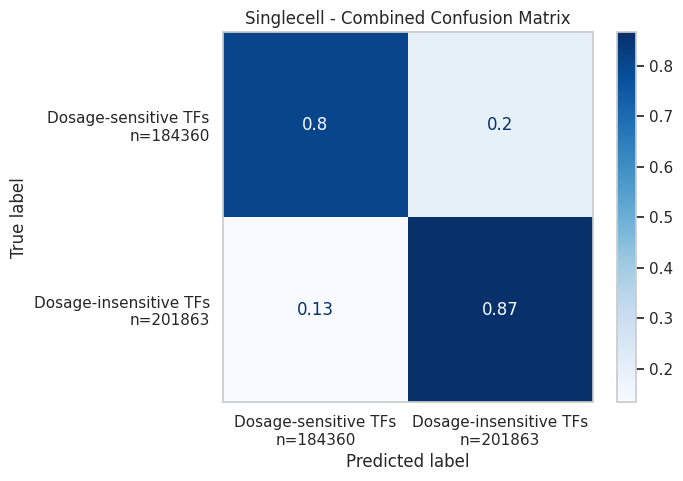

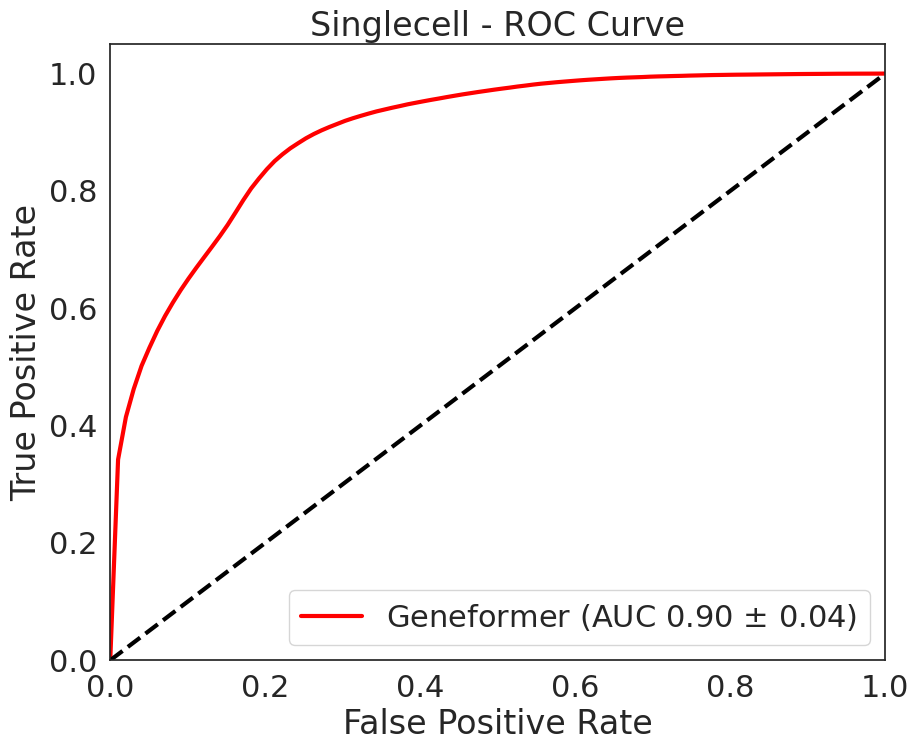

<Figure size 1000x1000 with 0 Axes>

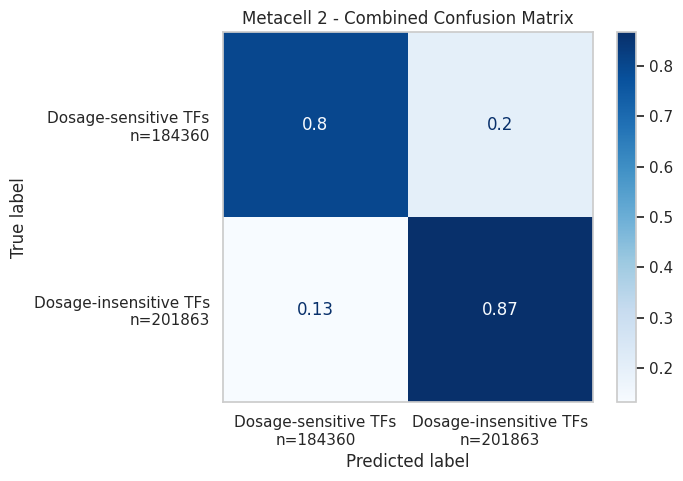

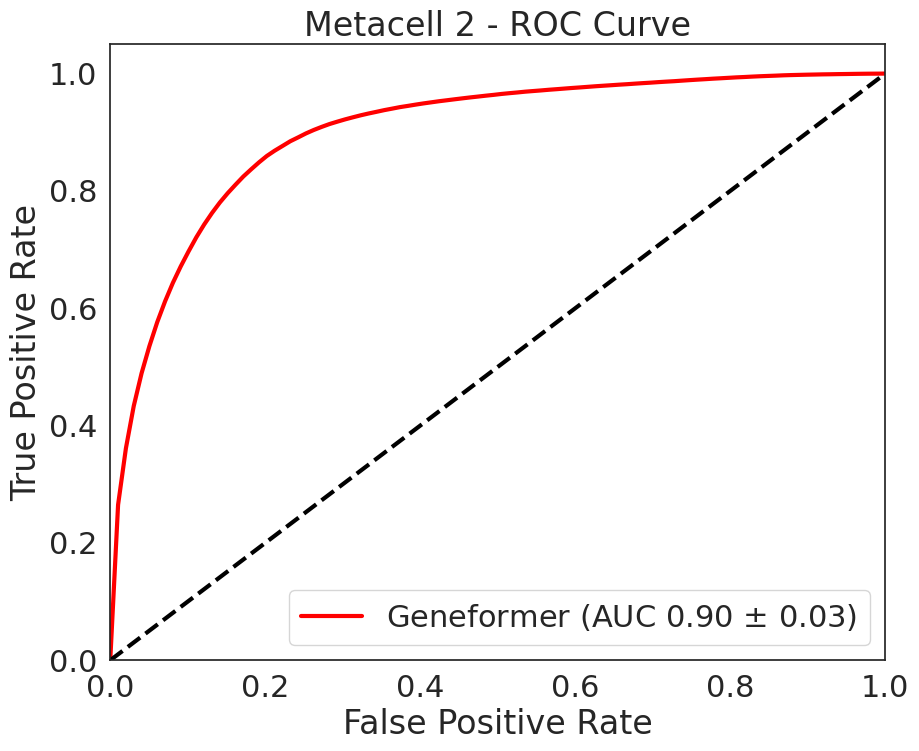

<Figure size 1000x1000 with 0 Axes>

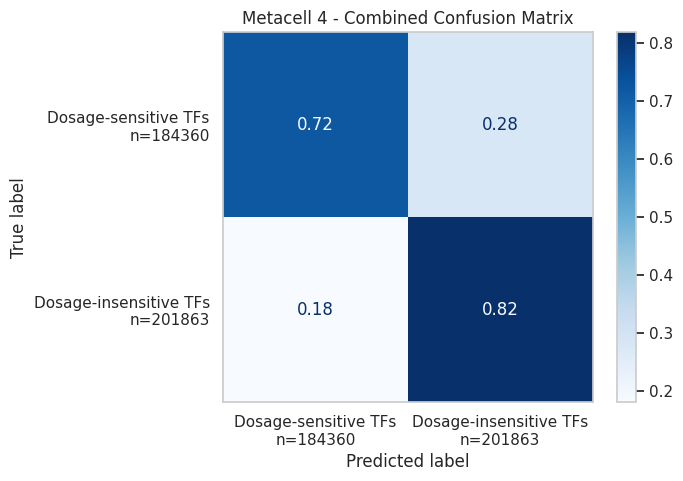

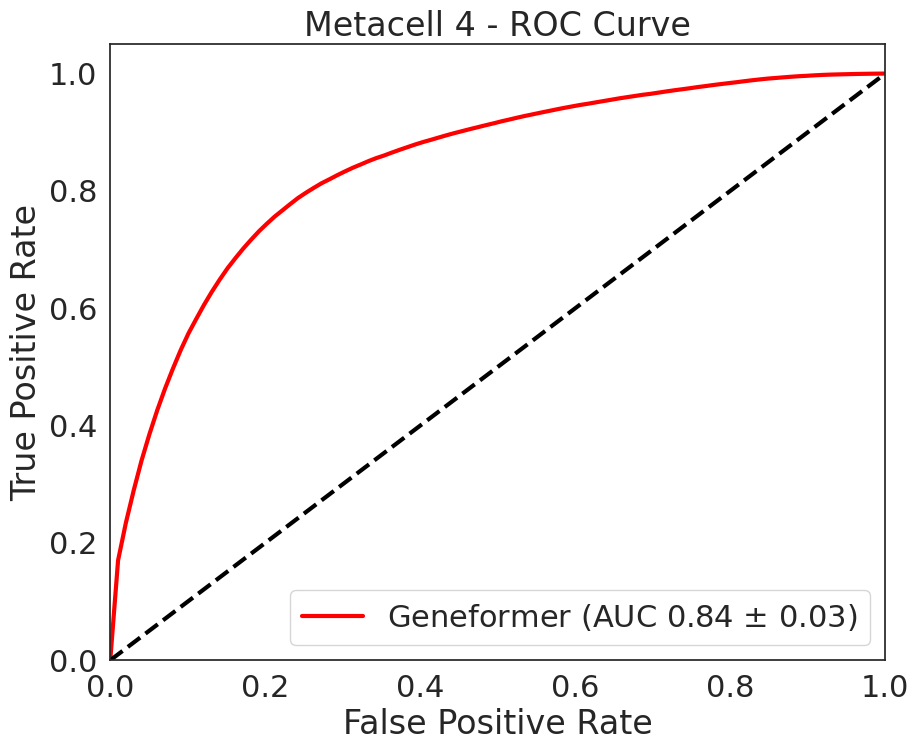

<Figure size 1000x1000 with 0 Axes>

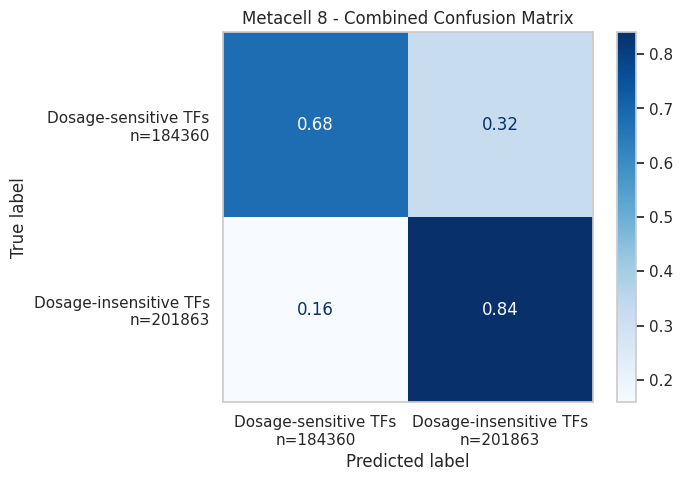

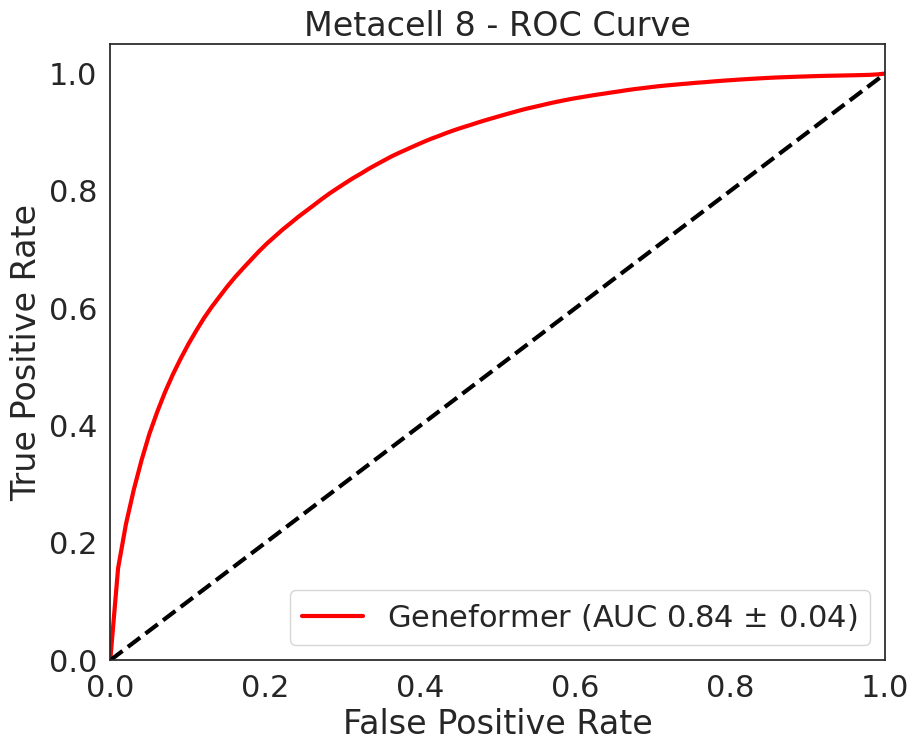

<Figure size 1000x1000 with 0 Axes>

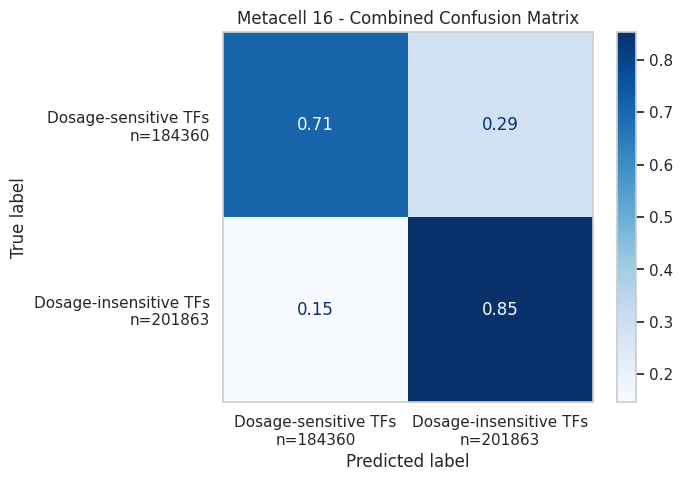

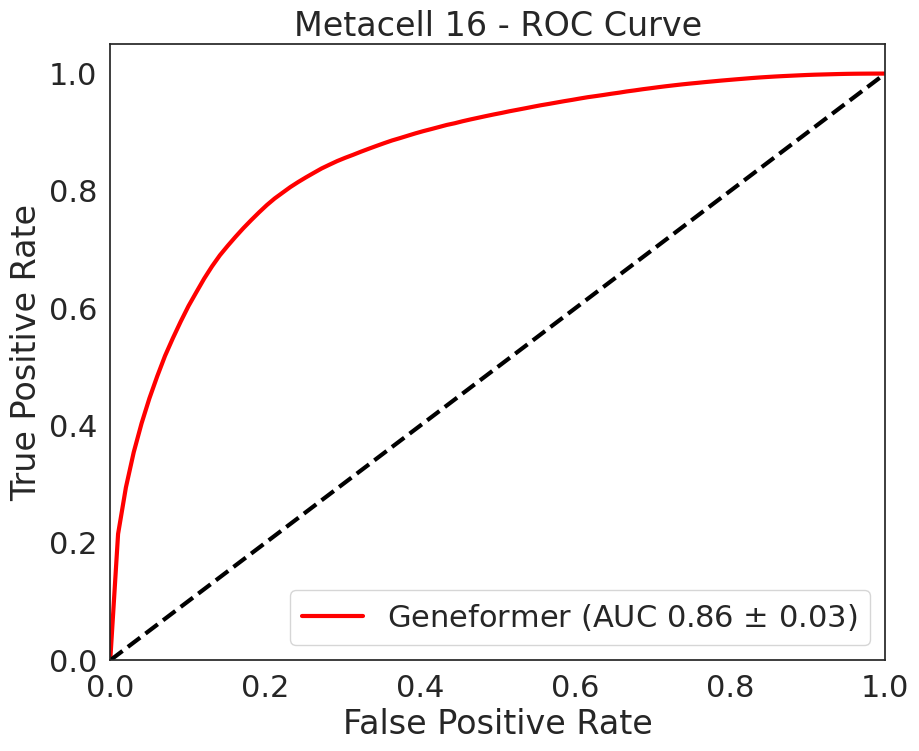

In [18]:
for agg_level, metrics in all_metrics.items():

    cc.plot_conf_mat(
    conf_mat_dict={agg_level.replace("_", " ").title() + " - Combined Confusion Matrix": metrics["conf_matrix"]},
    output_directory="figures",
    output_prefix=f"genecorpus_dosage_sensitivity_{agg_level}",
    )
    cc.plot_roc(
    roc_metric_dict={"Geneformer": metrics["all_roc_metrics"]},
    model_style_dict={"Geneformer": {"color": "red", "linestyle": "-"}},
    title=agg_level.replace("_", " ").title() + " - ROC Curve",
    output_directory="figures",
    output_prefix=f"genecorpus_dosage_sensitivity_roc_{agg_level}",
    )